In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size=50
TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [5]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)


newdataset = gtmatch(dataset1, dataset2, batch_size)

In [6]:
from models.RIM_v3 import RIM

In [7]:
model = RIM()

In [8]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [9]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [10]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1
st1=0
st2=-0
noise_weight=.5

for j in range(0,5):
    
    print(j)

    for i, batch in enumerate(data_loader):

        clean_images, gt = batch

        noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
        noisy_images=clean_images+noise

        if j==0 and i==0:
            loglikelihood=torch.zeros(noisy_images.shape)

        net_input=torch.cat([noisy_images, loglikelihood],dim=1)

        model.train()

        net_output, st1, st2 = model(net_input, st1, st2, i, j)
        
        st1=st1.detach()
        st2=st2.detach()

        pred_image=noisy_images+net_output
        loglikelihood=(pred_image+noise)-noisy_images
        loglikelihood=loglikelihood.detach()
        loss = loss_function(pred_image, clean_images)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        model.eval()

        val_loss = loss_function(net_output, noisy_images)
        val_losses.append(val_loss.item())


        if val_loss < best_val_loss:
            best_val_loss = val_loss

            net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
            noisy_input.append(net_input_np)

            denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
            denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            best_images.append(denoised_arr)

            clean_comp = clean_images.detach().cpu().numpy()[
                0, 0].astype(np.float64)
            clean_image_corr.append(clean_images)

            best_psnr = compare_psnr(clean_comp, denoised_arr)
            print("Loss (", i,"-",j, "): \t", round(loss.item(), 4))
            print("\tModel PSNR: ", np.round(best_psnr, 2))

0


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Loss ( 0 - 0 ): 	 0.0121
	Model PSNR:  22.2
Loss ( 3 - 0 ): 	 0.0104
	Model PSNR:  21.42
Loss ( 9 - 0 ): 	 0.008
	Model PSNR:  21.01
1
Loss ( 0 - 1 ): 	 0.0075
	Model PSNR:  21.72
2
3
4


In [16]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []


for i, batch in enumerate(validation_loader):

    clean_images, gt = batch
    
    noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
    gaussian=torch.randn(clean_images.size())*noise_weight
    noisy_images=clean_images+noise
        
    net_input=torch.cat([noisy_images, loglikelihood],dim=1)

    model.eval()

    denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))

    Model_loss.append(loss_function(denoised, clean_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), clean_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.m

Input PSNR =  21.19
Simple RIM PSNR =  21.7487

Simple RIM Loss =  tensor(0.0128)
Clipped Simple RIM Loss =  tensor(0.0105, dtype=torch.float64)


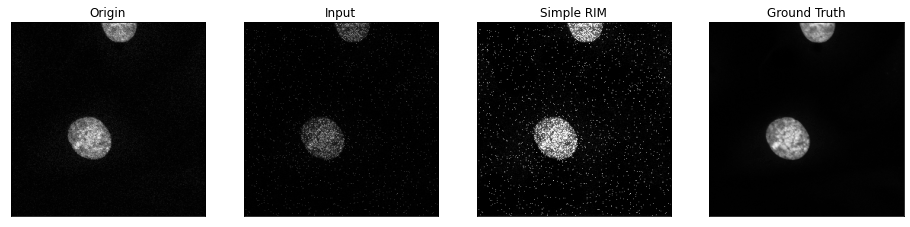

In [17]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM","Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [18]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input PSNR =  19.73
Average Simple RIM PSNR =  20.8663

Average Simple RIM Loss =  0.0108
Average Clipped Simple RIM Loss =  0.0093


## RIM with J-Invariant Mask

In [82]:
from mask_RIM_v3 import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1
st1=0
st2=0
noise_weight=.5

for j in range(0,5):
    
    print(j)

    for i, batch in enumerate(data_loader):
        clean_images, gt = batch

        noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
        gaussian=torch.randn(clean_images.size())*noise_weight
        noisy_images=clean_images+noise
        


        model.train()


        if i==0:
            loglikelihood=torch.zeros(noisy_images.shape)
            
        net_input=torch.cat([noisy_images, loglikelihood],dim=1)

            
        net_input, mask = masker.mask(net_input, i % (masker.n_masks - 1))


        net_output, st1, st2 = model(net_input, st1, st2, i, j)
        
        st1=st1.detach()
        st2=st2.detach()


        pred_image=net_output+noisy_images
        loglikelihood=(pred_image+noise)-noisy_images
        loglikelihood=loglikelihood.detach()

        loss = loss_function(pred_image*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        model.eval()
        val_loss = loss_function(pred_image*mask, noisy_images*mask)
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
            Jinv = noisy_images + \
                masker.infer_full_image(net_input, model, st1, st2, i, j)[0].detach()
            Jinv = np.clip(Jinv, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
            denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            clean_comp = clean_images.detach().cpu().numpy()[
                0, 0].astype(np.float64)

            best_psnr = compare_psnr(clean_comp, Jinv)

            noisy_input.append(net_input_np)
            best_images.append(denoised_arr)
            best_Jimages.append(Jinv)
            clean_image_corr.append(clean_images)
            print("Loss (", i,"-",j, "): \t", round(loss.item(), 4))
            print("\tModel PSNR: ", np.round(best_psnr, 2))

0


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Loss ( 0 - 0 ): 	 0.0015
	Model PSNR:  14.65
Loss ( 1 - 0 ): 	 0.0014
	Model PSNR:  14.59
Loss ( 2 - 0 ): 	 0.0013
	Model PSNR:  14.71
Loss ( 3 - 0 ): 	 0.0012
	Model PSNR:  15.45
Loss ( 4 - 0 ): 	 0.001
	Model PSNR:  14.99
Loss ( 5 - 0 ): 	 0.0009
	Model PSNR:  15.22
Loss ( 6 - 0 ): 	 0.0008
	Model PSNR:  15.32
Loss ( 7 - 0 ): 	 0.0008
	Model PSNR:  15.64
Loss ( 8 - 0 ): 	 0.0007
	Model PSNR:  16.65
Loss ( 9 - 0 ): 	 0.0006
	Model PSNR:  16.99
Loss ( 10 - 0 ): 	 0.0005
	Model PSNR:  16.19
Loss ( 11 - 0 ): 	 0.0005
	Model PSNR:  17.32
Loss ( 12 - 0 ): 	 0.0004
	Model PSNR:  16.99
Loss ( 13 - 0 ): 	 0.0004
	Model PSNR:  16.23
Loss ( 14 - 0 ): 	 0.0003
	Model PSNR:  16.48
Loss ( 15 - 0 ): 	 0.0002
	Model PSNR:  16.98
1
Loss ( 0 - 1 ): 	 0.0002
	Model PSNR:  19.45
Loss ( 1 - 1 ): 	 0.0002
	Model PSNR:  18.63
Loss ( 2 - 1 ): 	 0.0001
	Model PSNR:  18.62
Loss ( 3 - 1 ): 	 0.0001
	Model PSNR:  20.0
Loss ( 4 - 1 ): 	 0.0001
	Model PSNR:  18.67
Loss ( 5 - 1 ): 	 0.0001
	Model PSNR:  18.58
Loss

In [87]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    clean_images, gt = batch
    
    noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
    gaussian=torch.randn(clean_images.size())*noise_weight
    noisy_images=clean_images+noise

    model.eval()

    net_input=torch.cat([noisy_images, loglikelihood],dim=1)

    denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images + \
        masker.infer_full_image(net_input, model, st1, st2, i, j)[0].detach()
    Jinv_np = np.clip(Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/w

Input PSNR =  18.85
Simple RIM PSNR =  19.9975
J-Invariant RIM PSNR =  19.9972

Simple RIM Loss =  tensor(0.)
Clipped Simple RIM Loss =  tensor(0.0211, dtype=torch.float64)

J-Invariant RIM Loss =  tensor(0.)
Clipped J-Invariant RIM Loss =  tensor(0.0211, dtype=torch.float64)


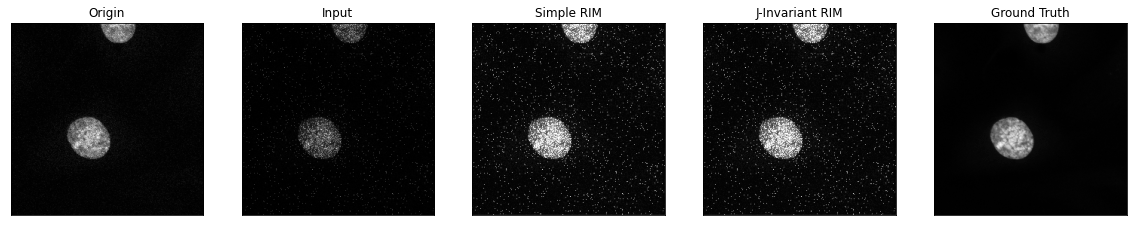

In [90]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [89]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))

Average Input PSNR =  19.79
Average Simple RIM PSNR =  20.5706
Average J-Invariant RIM PSNR =  20.5703

Average Simple RIM Loss =  0.0
Average Clipped Simple RIM Loss =  0.0183

Average J-Invariant RIM Loss =  0.0
Average Clipped J-Invariant RIM Loss =  0.0183
